## Computational Chemistry for Experimentalists
## Module 3: Geometry Optimization

Determining a local minimum geometry is an essential first step of most molecular simulations. Here we discuss some of the ideas behind geometry optimization and show some examples. 

This first block imports all of the necessary Python modules. If these aren't installed, this will fail. 

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from pyscf import gto,scf
from pyscf.tools import cubegen 
import py3Dmol
import numpy 
import matplotlib.pyplot as plt
from pyscf.geomopt.geometric_solver import optimize

### Part 1: Optimization on a one-dimensional PES, carbon monoxide 

Predict the ground-state potential energy surface for carbon monoxide, by computing the energy at multiple bond lengths. We'll compute the energy of CO molecule relative to the energies of isolated ground-state C and O atoms. 

In [5]:
basis='3-21g'
hartreetokcalmol = 627.5095
mc=gto.Mole(atom='C',spin=2,basis=basis)
mc.build()
mfc=scf.UHF(mc)
mfc.kernel()
mo=gto.Mole(atom='O',spin=2,basis=basis)
mo.build()
mfo=scf.UHF(mo)
mfo.kernel()
Eat=mfc.e_tot+mfo.e_tot


converged SCF energy = -37.4810698325834  <S^2> = 2.0009709  2S+1 = 3.0006472
converged SCF energy = -74.3936572122619  <S^2> = 2.0011  2S+1 = 3.0007332


In [72]:
rs=[0.5,0.6,0.7,0.8,0.9,1.0,1.05,1.1,1.15,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0,2.2,2.3,2.5,2.7,3.0]
des=[]
Pg=None
for r in rs:
    geom='C 0.0 0.0 0.0; O 0.0 0.0 %.2f'%(r)
    mco=gto.Mole(atom=geom,basis=basis)
    mco.build()
    nao=mco.nao
    mfco=scf.RHF(mco)
    mfco.kernel(dm0=Pg)
    Pg=mfco.make_rdm1() # Use the current density matrix as the next guess 
    de=hartreetokcalmol*(mfco.e_tot-Eat)
    des.append(de)

converged SCF energy = -106.228833588758
converged SCF energy = -109.159183844379
converged SCF energy = -110.695668088621
converged SCF energy = -111.481074787975
converged SCF energy = -111.866873402071
converged SCF energy = -112.037413944643
converged SCF energy = -112.074717240556
converged SCF energy = -112.091075548599
converged SCF energy = -112.092249412632
converged SCF energy = -112.082590552839
converged SCF energy = -112.043029018406
converged SCF energy = -111.989686316324
converged SCF energy = -111.931901121576
converged SCF energy = -111.874920863211
converged SCF energy = -111.822695718461
converged SCF energy = -111.77972427895
converged SCF energy = -111.727227698411
converged SCF energy = -111.701207004229
converged SCF energy = -111.692816131984
converged SCF energy = -111.681019278631
converged SCF energy = -111.673473643402
converged SCF energy = -111.666763667955


Plot the potential energy surface obtained. Computing all of these points for a high-dimensional PES would be very expensive, which is why we use "geometry optimization" algorithms instead. 

The dissociation limit would be zero if we used a more accurate electronic structure approximation. We'll discuss this much more in a later module 

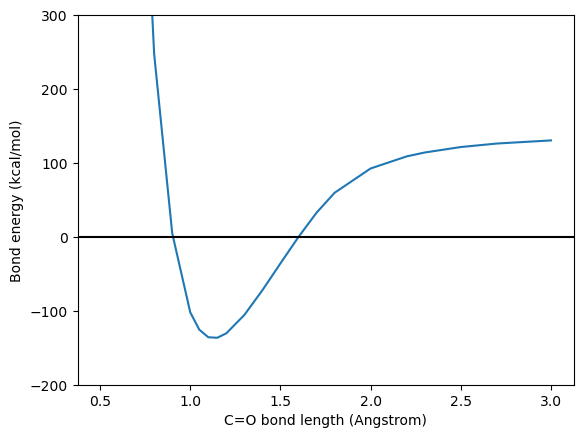

In [73]:
plt.plot(rs,des)
plt.xlabel('C=O bond length (Angstrom)')
plt.ylabel('Bond energy (kcal/mol)')
plt.axhline(y=0, color='black',linestyle='-')
ax=plt.gca()
ax.set_ylim(-200,300)
plt.show()

Do a PySCF geometry optimization starting from a C=O bond length 1.7 Angstrom. Use the Jupyter 'magic command' to collect geometry and energy from each step of the optimization into a file 

In [74]:
%%capture cap 
mco=gto.Mole(atom='C 0.0 0.0 0.0; O 0.0 0.0 1.7',basis=basis)
mco.build()
mfco=scf.RHF(mco)
#mfco.kernel()
optimize(mfco)

In [75]:
#cap()
with open('COopt.txt', 'w') as file:
    file.write(cap.stdout)

Read the file to determine the dissociaton energy and C=O bond length at each step of the geometry optimization 

In [76]:
DEopt=[]
Csopt=[]
Osopt=[]
with open('COopt.txt', 'r') as file:
    for line in file:
        fields=line.split()
        if(len(fields)>0):
            if(fields[0]=='cycle'):
                DE=hartreetokcalmol*(float(fields[4])-Eat)
                DEopt.append(DE)
            if(fields[0]=='C'):
                Csopt.append(numpy.array((float(fields[2]),float(fields[3]),float(fields[4]))))
            if(fields[0]=='O'):
                Osopt.append(numpy.array((float(fields[2]),float(fields[3]),float(fields[4]))))
Rsopt=[]
for i in range(len(Csopt)):
    v=Csopt[i]-Osopt[i]
    R=numpy.dot(v,v)**0.5
    Rsopt.append(R)
                             
#print(Rsopt
labs=numpy.array(range(len(Csopt)))+1

Plot each step as a point on the potential energy surface, labeled with step number. The algorithm "walks downhill" in steps 1-3, overshoots the minimum at step 4, then moves back at step 5 and converges by step 7. 

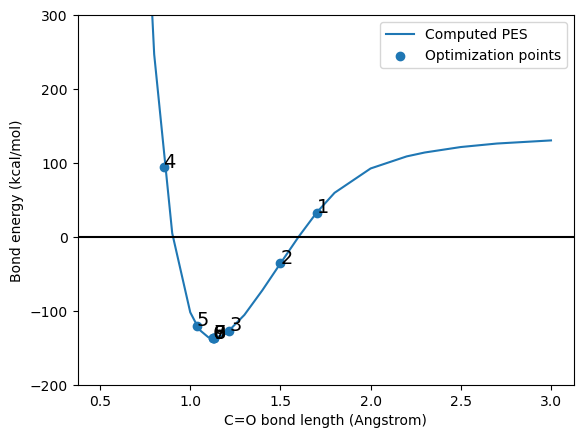

In [77]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rs,des,label="Computed PES")
ax1.scatter(Rsopt,DEopt,marker='o',label="Optimization points")
ax1.set_ylim(-200,300)
for i, txt in enumerate(labs):
    ax1.annotate(txt, (Rsopt[i], DEopt[i]),fontsize=14)
plt.xlabel('C=O bond length (Angstrom)')
plt.ylabel('Bond energy (kcal/mol)')
plt.axhline(y=0, color='black',linestyle='-')
plt.legend(loc='upper right')
plt.show()

### Part 2: Optimizing multiple local minima for 1-pentanol

In this example, we consider a molecule with multiple local minima. While these will interconvert in the gas phase or solution at normal temperatures, they need to be treated separately in geometry optimizations. We generate 100 conformers with the RDKit, optimize each with a MM force field, and view the first few nondegenerate optimized conformers.

In [62]:
m=Chem.MolFromSmiles('CCCCCO')
m2=Chem.AddHs(m)
confids=AllChem.EmbedMultipleConfs(m2,numConfs=100)
print('Number of conformers: %d'%(len(confids)))
uniqueEs=[]
uniqueIDs=[]
for confid in confids:
    AllChem.MMFFOptimizeMolecule(m2,confId=confid)
    ff = AllChem.MMFFGetMoleculeForceField(m2, AllChem.MMFFGetMoleculeProperties(m2), confId=confid)
    E=ff.CalcEnergy()
    keep=1
    for Eold in uniqueEs:
        if((E-Eold)**2<0.000001):
            keep=0
    if(keep>0):
        uniqueEs.append(E)
        uniqueIDs.append(confid)
        
# Sort by energy 
sortedEs=[(x,y) for x,y in sorted(zip(uniqueEs,uniqueIDs))]
Emin=sortedEs[0][0]
print('Lowest energy: %.4f'%(Emin))
    
p = py3Dmol.view(width=600,height=200,viewergrid=(2,4))
for ij in range(8):
    i=ij%4
    j=ij/4
    ss=sortedEs[ij]
    confid=ss[1]
    E=ss[0]
    DE=(E-Emin)
    DElabel='%.2f'%(DE)
    p.addModel(Chem.MolToMolBlock(m2,confId=confid), 'sdf',viewer=(j,i))
    p.addLabel(DElabel,{'inFront':True,'fontColor':'black','backgroundColor':'white'},viewer=(j,i))
    p.setStyle({'stick':{},'sphere':{"scale":0.3}},viewer=(j,i))
p.zoomTo()
#p.update()
p.render()


Number of conformers: 100
Lowest energy: -2.2130


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Part 3: A more complicated optimization, saqinavir 

Optimizing the geometries of large molecules can be challenging. In this example, I show the RDKit and PySCF optimization of a fragment of the anti-AIDS drug saquinavir. I intentionally include a mistake, leaving out two hydrogen atoms. The molecule is still a singlet with charge +1, however, the geometry is severely distorted due to the diradical character. 

I start the geometry optimization from the canonical SMILES available from PubChem 

In [94]:
#m=Chem.MolFromSmiles('CC(C)(C)NC(=O)C1CC2C[CH]CCC2CN1CC(C(CC3=CC=CC=C3)[N]C(=O)C(CC(=O)[NH3+])NC(=O)C4=NC5=CC=CC=C5C=C4)O')
m=Chem.MolFromSmiles('CC(C)(C)NC(=O)C1CC2C[CH]CCC2CN1CC(C[N]C(=O)C(CC(=O)[NH3+])NC(=O))O')
m2=Chem.AddHs(m)
AllChem.EmbedMolecule(m2)
mb=Chem.MolToMolBlock(m2)
p=py3Dmol.view(width=400,height=400)
p.addModel(mb,'sdf')
p.setStyle({'stick':{},'sphere':{"scale":0.3}})
p.zoomTo()
p.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [95]:
elements = [atom.GetSymbol() for atom in m2.GetAtoms()]
coordinates = m2.GetConformer().GetPositions()
atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]

pyscf_mole = gto.Mole(basis="sto-3g",charge=1)
pyscf_mole.atom = atoms
pyscf_mole.build();

mf=scf.RHF(pyscf_mole)

In [ ]:
%%capture cap 
optimize(mf)


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -4.671597  -2.753963   1.438788    0.000000  0.000000  0.000000
   C  -4.301612  -1.332185   1.799175    0.000000  0.000000 -0.000000
   C  -4.018816  -1.331837   3.300842    0.000000  0.000000  0.000000
   C  -5.487849  -0.458304   1.551415    0.000000  0.000000  0.000000
   N  -3.132287  -0.965217   1.034445    0.000000  0.000000  0.000000
   C  -2.569097   0.306815   1.175066    0.000000  0.000000  0.000000
   O  -3.123133   1.106459   1.991903    0.000000  0.000000  0.000000
   C  -1.380159   0.829049   0.463747    0.000000  0.000000  0.000000
   C  -1.606352   2.199438  -0.102976    0.000000  0.000000  0.000000
   C  -2.403617   2.217771  -1.346966    0.000000  0.000000  0.000000
   C  -3.877392   2.410459  -0.956482    0.000000  0.000000  0.000000
   C  -4.595399   2.804494  -2.225506    0.000000  0.000000  0.000000
   C  -4.591796   1.560168  -3.1

cycle 1: E = -1482.29818092  dE = -1482.3  norm(grad) = 0.519307

Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -4.548768  -2.819996   1.367783    0.122829 -0.066033 -0.071004
   C  -4.288907  -1.371995   1.790008    0.012705 -0.039810 -0.009167
   C  -4.048170  -1.397195   3.310207   -0.029354 -0.065358  0.009366
   C  -5.540399  -0.561205   1.526484   -0.052550 -0.102901 -0.024931
   N  -3.116092  -0.896268   1.067286    0.016196  0.068949  0.032842
   C  -2.602641   0.396910   1.225293   -0.033545  0.090095  0.050227
   O  -3.143746   1.209298   2.011095   -0.020614  0.102839  0.019192
   C  -1.395709   0.907528   0.490601   -0.015550  0.078479  0.026855
   C  -1.622600   2.282433  -0.111338   -0.016248  0.082996 -0.008362
   C  -2.439244   2.275547  -1.368534   -0.035627  0.057776 -0.021568
   C  -3.921396   2.487752  -0.967200   -0.044003  0.077293 -0.010718
   C  -4.630375   2.838334  -2.254336

cycle 2: E = -1482.38423438  dE = -0.0860535  norm(grad) = 0.384861

Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -4.539244  -2.858765   1.415304    0.009524 -0.038769  0.047521
   C  -4.212942  -1.371387   1.772572    0.075965  0.000608 -0.017436
   C  -3.919319  -1.299229   3.301538    0.128851  0.097967 -0.008669
   C  -5.454002  -0.486573   1.474610    0.086396  0.074633 -0.051874
   N  -3.032918  -0.960366   0.991968    0.083174 -0.064098 -0.075319
   C  -2.627740   0.353386   1.222418   -0.025098 -0.043524 -0.002875
   O  -3.255317   1.030263   2.018376   -0.111571 -0.179036  0.007281
   C  -1.383398   0.899774   0.461989    0.012311 -0.007754 -0.028612
   C  -1.634276   2.310511  -0.126658   -0.011676  0.028078 -0.015320
   C  -2.516273   2.312696  -1.392197   -0.077029  0.037149 -0.023664
   C  -4.012960   2.529107  -0.915093   -0.091564  0.041355  0.052107
   C  -4.699066   2.801508  -2.225

Your assignment for this module has two parts 

Part 1: Optimize the enol and keto tautomers of acetone, and determine the isomerization energy. Compare the results of the RDKit to results reoptimizing with PySCF. 

Part 2: Find and fix the error in the saqinavir input geometry. 

For 50 points extra credit, fix the energy labels on the pentanol figure to be permanently underneath the pictured geometry. 